# Getting Started with EDA on Time Series Data

In this notebook we present some tips and tricks to start with an exploratory data analysis with time series data. The success of any data analysis project depends on the EDA phase. We do not intend to give a complete guide on how to run an eda (especially because it depends on the use-case and the data), but we focus in two important components: (i) Data Visualization (ii) Treating missing values. 

**Data Source:** We are going to consider the data used for the [Prophet meetup](https://github.com/juanitorduz/btsa/blob/master/meetup.md).

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [2]:
raw_data_df = pd.read_csv('../../../data/sample_data_1.csv')

raw_data_df.head()

date  media     sales
0  2018-01-03    0.0  6.258472
1  2018-01-04    0.0  6.170889
2  2018-01-05    0.0  5.754669
3  2018-01-06    0.0  5.968413
4  2018-01-07    0.0  5.285262

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1367 non-null   object 
 1   media   1367 non-null   float64
 2   sales   1275 non-null   float64
dtypes: float64(2), object(1)
memory usage: 32.2+ KB


## Data Preparation

Let us look into missing values.

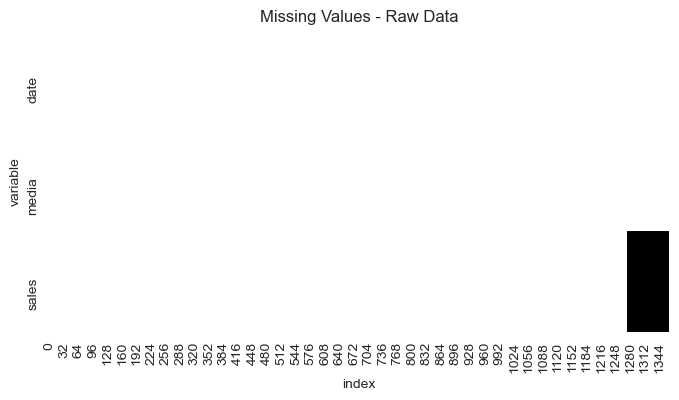

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(data=raw_data_df.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values - Raw Data', xlabel='index', ylabel='variable');

We just have missing values for the period we want to predict (> July 2021). Since we do not want to do any forecasting we remove this period and generate some date features.

In [5]:
data_df = raw_data_df \
    .copy() \
    .query('sales.notnull()') \
    .assign(
        date = lambda x: pd.to_datetime(x['date']),
        year = lambda x: x['date'].dt.year,
        month = lambda x: x['date'].dt.month,
        day = lambda x: x['date'].dt.day,
        dayofyear = lambda x: x['date'].dt.dayofyear,
    )

data_df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275 entries, 0 to 1274
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1275 non-null   datetime64[ns]
 1   media      1275 non-null   float64       
 2   sales      1275 non-null   float64       
 3   year       1275 non-null   int64         
 4   month      1275 non-null   int64         
 5   day        1275 non-null   int64         
 6   dayofyear  1275 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 79.7 KB


We will focus on the `sales` variable in this notebook. 

## Data Visualization

We start by plotting the data. We will mainly use [seaborn](https://seaborn.pydata.org/) for data visualization.

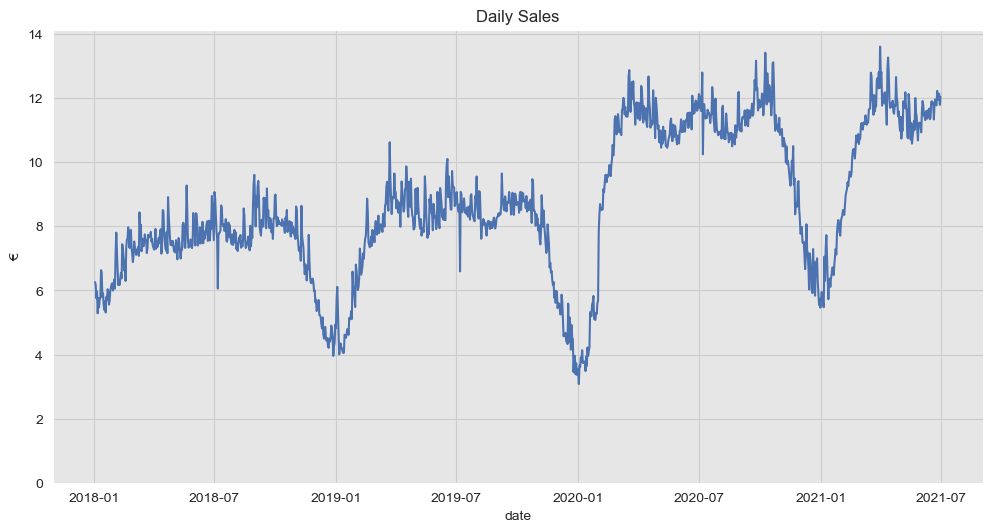

In [6]:
# It is important to give meaningful labels to the axes and title plots.
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', data=data_df, color=sns_c[0], ax=ax)
ax.set(title='Daily Sales', xlabel='date', ylabel='€', ylim=(0, None));

Here are some initial observations on the data:
- We have daily data.
- There is a clear (yearly) seasonal pattern.
- There is a positive trend. 
- There seems to be a [structural break](https://en.wikipedia.org/wiki/Structural_break) at the beginng of 2020.
- There is a drop every July.

### Aggregations

If you want to see a more "global" behaviour you can either (i) aggregate or (ii) smooth. Let us see how the data looks when we sum the sales over the days of the week.

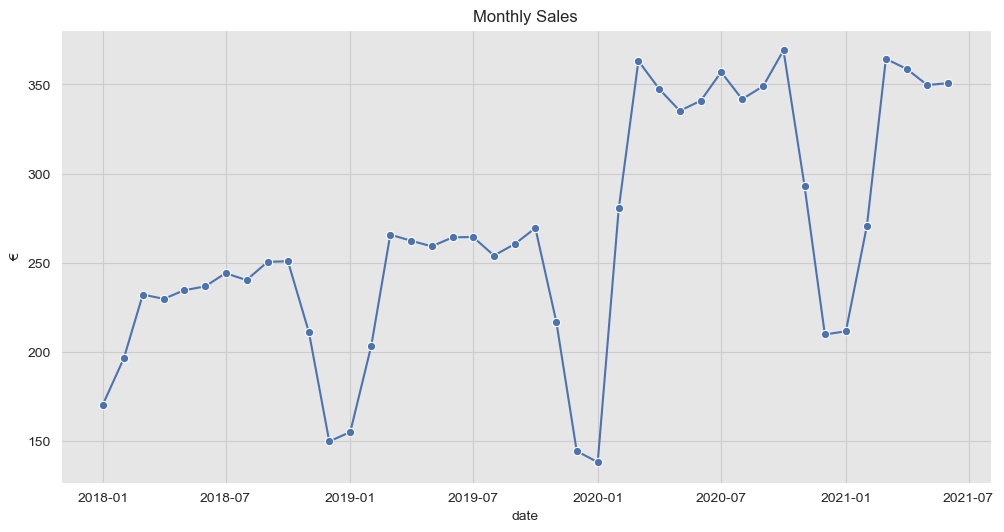

In [7]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .assign(
        date = lambda x: pd.to_datetime(x['year'].astype('str') + '-' + x['month'].astype('str') + '-01')
    ) \
    .pipe((sns.lineplot, 'data'), 
        x='date', 
        y='sales', 
        marker='o',
        ax=ax
    )
ax.set(title='Monthly Sales', ylabel='€');

### Distributions

Besides the time dependency it is also useful to see the distribution. 

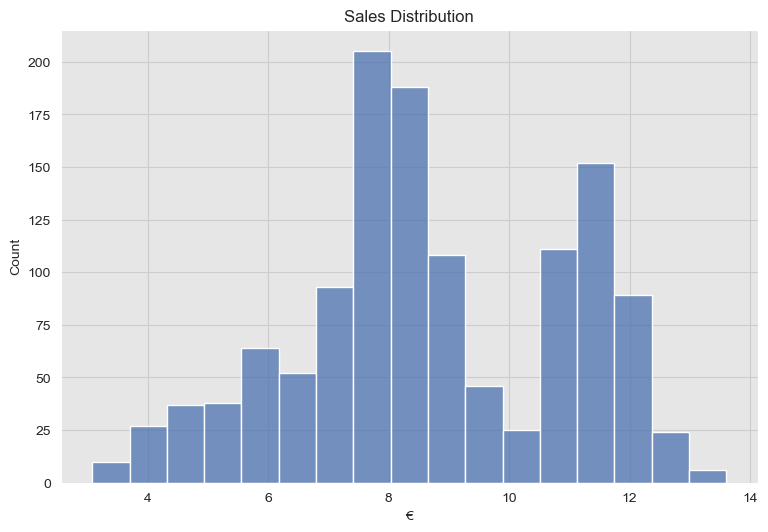

In [8]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(x='sales', data=data_df, ax=ax)
ax.set(title='Sales Distribution', xlabel='€');

The two peaks on the distribution reflect the two levels we see on the data (pre and post `01-01-2020`). We can see this better if we color by year.

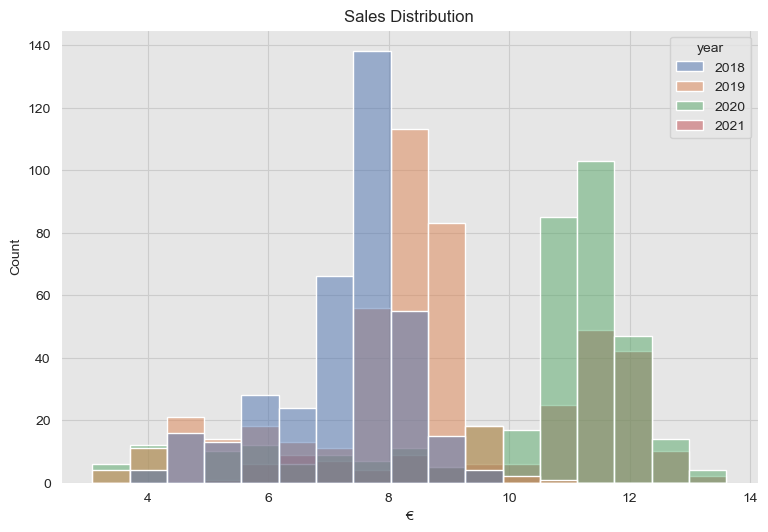

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.histplot(
    x='sales', 
    data=data_df.assign(year= lambda x: x['year'].astype('str')), 
    hue='year', 
    ax=ax
)
ax.set(title='Sales Distribution', xlabel='€');

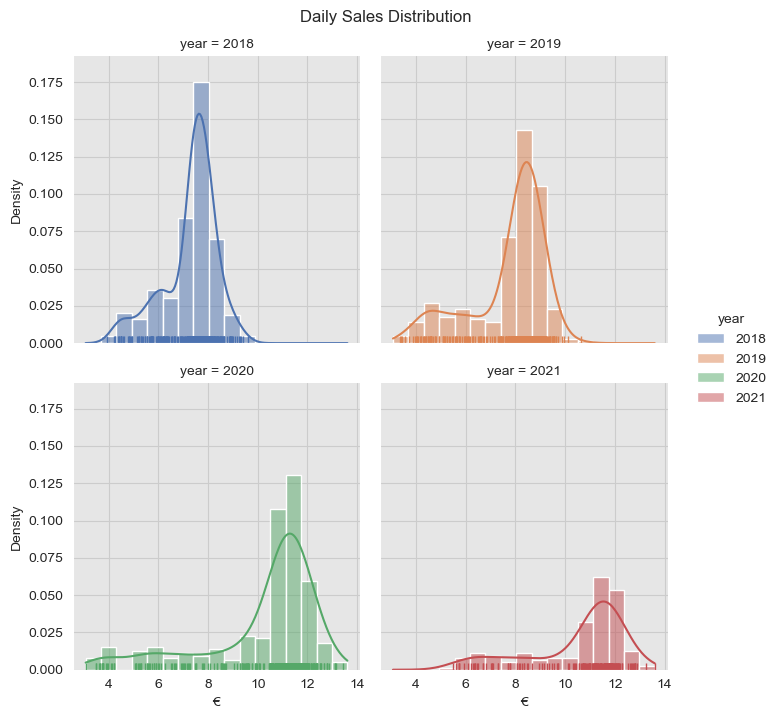

In [10]:
g = sns.displot(
    x='sales',
    data=data_df.assign(year= lambda x: x['year'].astype('str')),
    rug=True,
    kde=True,
    stat='density',
    col='year',
    col_wrap=2,
    hue='year',
    height=3.5
)
g.set_axis_labels('€')
g.fig.suptitle('Daily Sales Distribution', y=1.02);

### Seasonality

Now let's generate plots to compare the yearly seasonality.

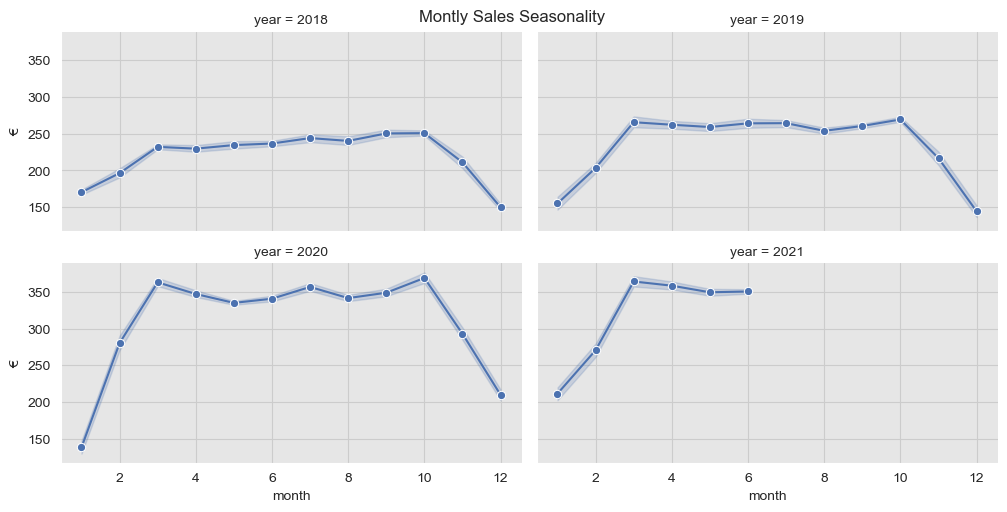

In [11]:
g = sns.relplot(
    data=data_df,
    x='month', 
    y='sales', 
    col='year', 
    kind='line', 
    estimator='sum',
    marker='o',
    col_wrap=2, 
    height=2.5, 
    aspect=2, 
    legend=True
)
g.set_axis_labels('month', '€')
g.fig.suptitle('Montly Sales Seasonality');

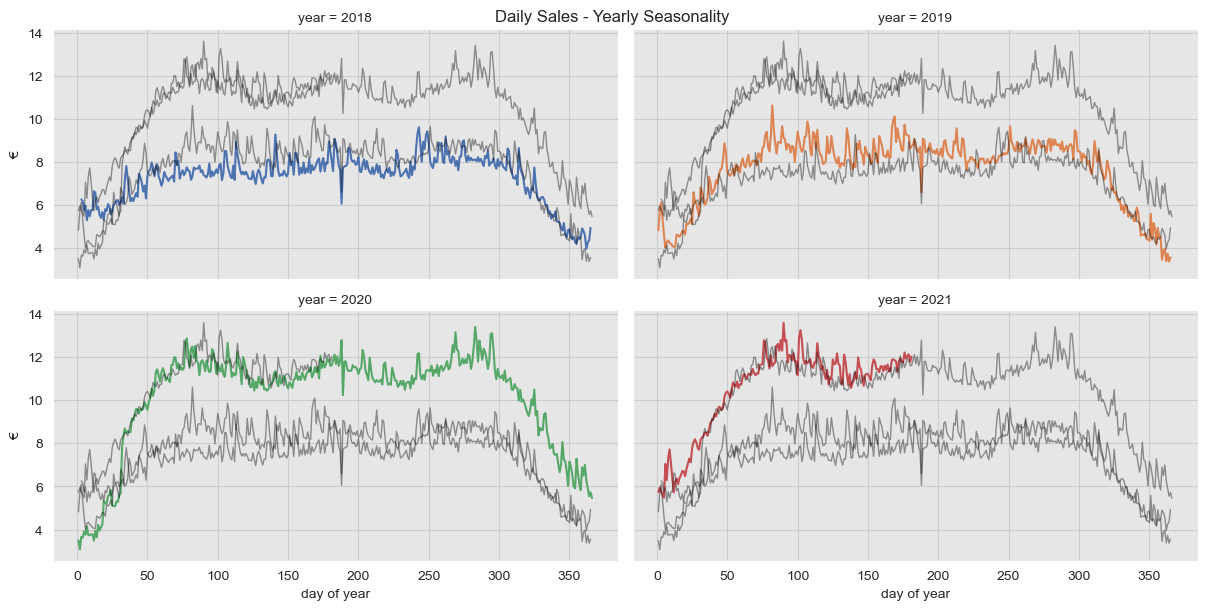

In [12]:
# see https://seaborn.pydata.org/examples/timeseries_facets.html
g = sns.relplot(
    data=data_df,
    x='dayofyear', 
    y='sales', 
    col='year', 
    hue='year',
    palette=sns_c[:4],
    kind='line', 
    estimator=None,
    col_wrap=2, 
    height=3, 
    aspect=2, 
    legend=False
)
for year, ax in g.axes_dict.items():
    sns.lineplot(
        x='dayofyear', 
        y='sales', 
        data=data_df.query(f'year != {year}'),
        units='year',
        estimator=None, 
        color='black', 
        alpha=0.4,
        linewidth=1, 
        ax=ax
    )

g.set_axis_labels('day of year', '€')
g.fig.suptitle('Daily Sales - Yearly Seasonality');

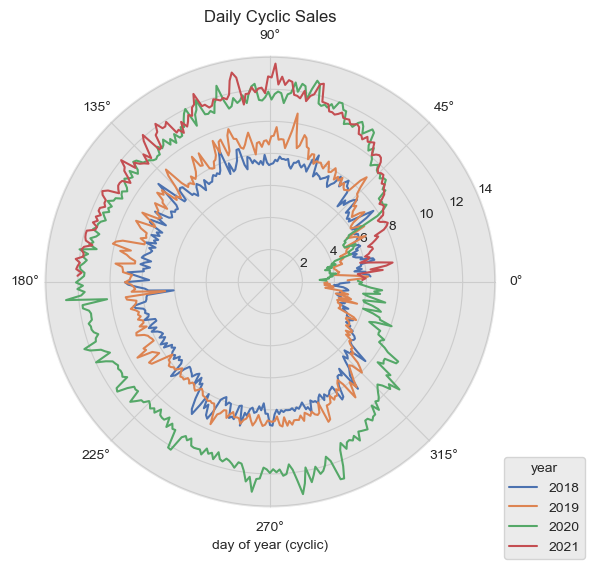

In [13]:
ax = plt.subplot(111, projection='polar')

data_df \
    .assign(
        day_of_year_cyclic = lambda x: x['dayofyear'].transform(lambda x: 2*np.pi*x/365.5),
        year = lambda x: x['year'].astype('str')
    ) \
    .pipe((sns.lineplot, 'data'), 
        x='day_of_year_cyclic', 
        y='sales', 
        hue='year',
        ax=ax
    )

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0))
ax.set(title='Daily Cyclic Sales', ylabel='', xlabel='day of year (cyclic)');

Next we want to compare the sales development year-over-year for every month.

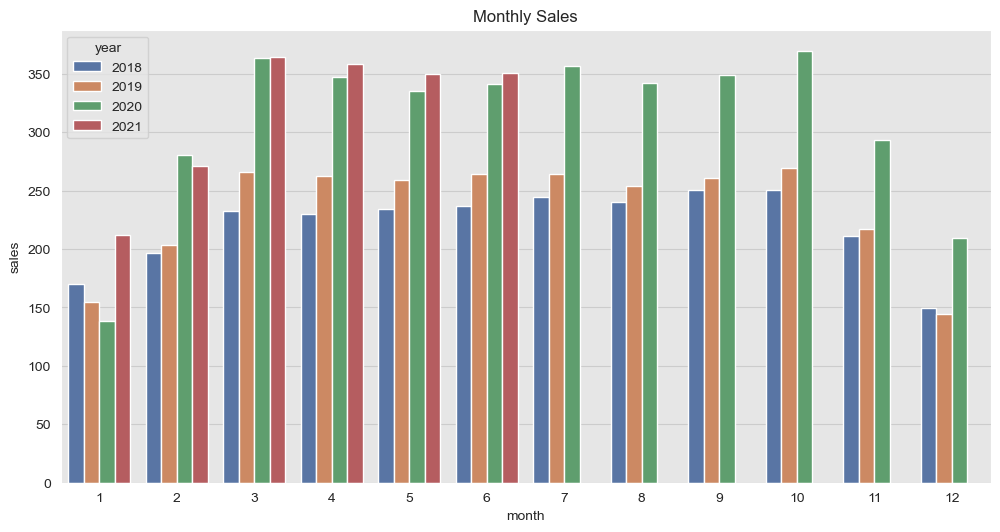

In [14]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='sales', 
        hue='year', 
        ax=ax
    )
ax.set(title='Monthly Sales');

Most of the times we do not just care about the absolute values but also about the relatiive growth:

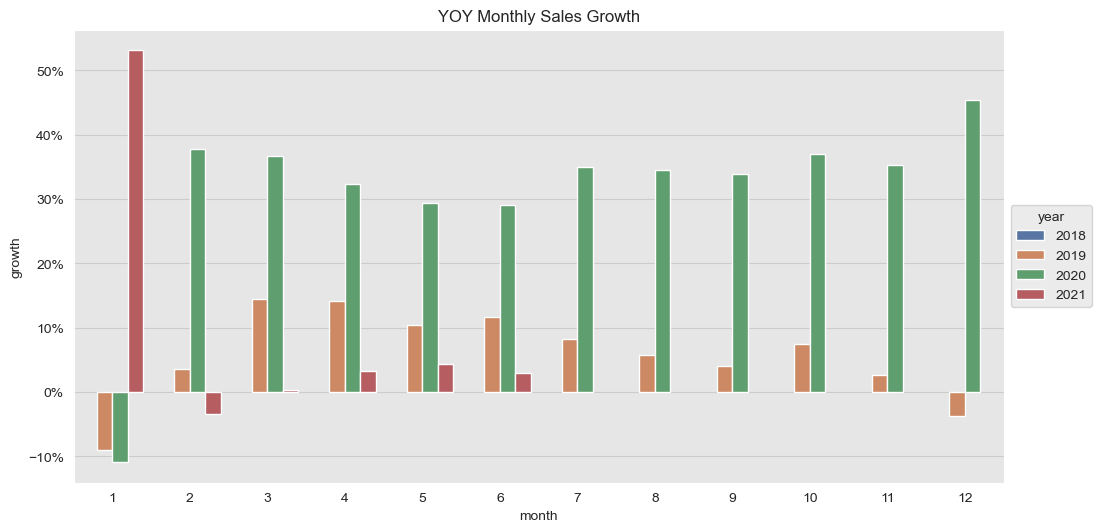

In [15]:
fig, ax = plt.subplots()
data_df \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .sort_values(['month', 'year']) \
    .assign(
        sales_lag = lambda x: x.groupby('month')['sales'].transform('shift'),
        yoy_monthly_growth = lambda x: x['sales'].div(x['sales_lag']) - 1
    ) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='yoy_monthly_growth', 
        hue='year', 
        ax=ax
    )
ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set(title='YOY Monthly Sales Growth', ylabel='growth');

Finally, we can also plot the monthly sales share over each year.

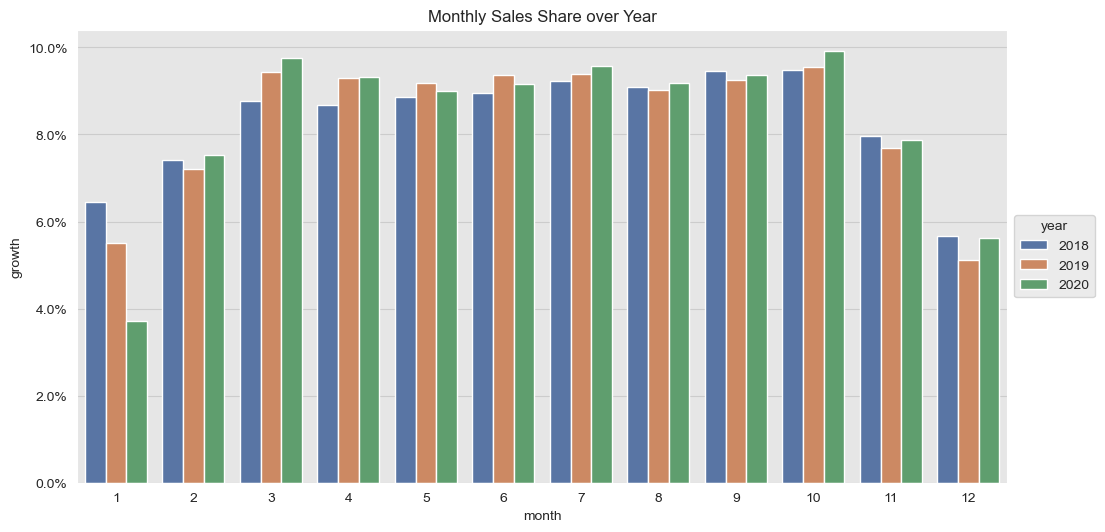

In [16]:
fig, ax = plt.subplots()
data_df \
    .query('year < 2021') \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'sales': np.sum}) \
    .assign(
        yearly_sales = lambda x: x.groupby('year')['sales'].transform(np.sum), 
        montly_sales_share = lambda x: x['sales'].div(x['yearly_sales'])
    ) \
    .pipe((sns.barplot, 'data'), 
        x='month', 
        y='montly_sales_share', 
        hue='year',
        ax=ax
    )
ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set(title='Monthly Sales Share over Year', ylabel='growth');

### Many Variables

As mentioned in the introduction, we are going to focus on the `sales` data. Nevertheless, we provide code to plot two variables at the same time which do not have the same scale. For comparing variables a correlation analysis might be a good next step.  

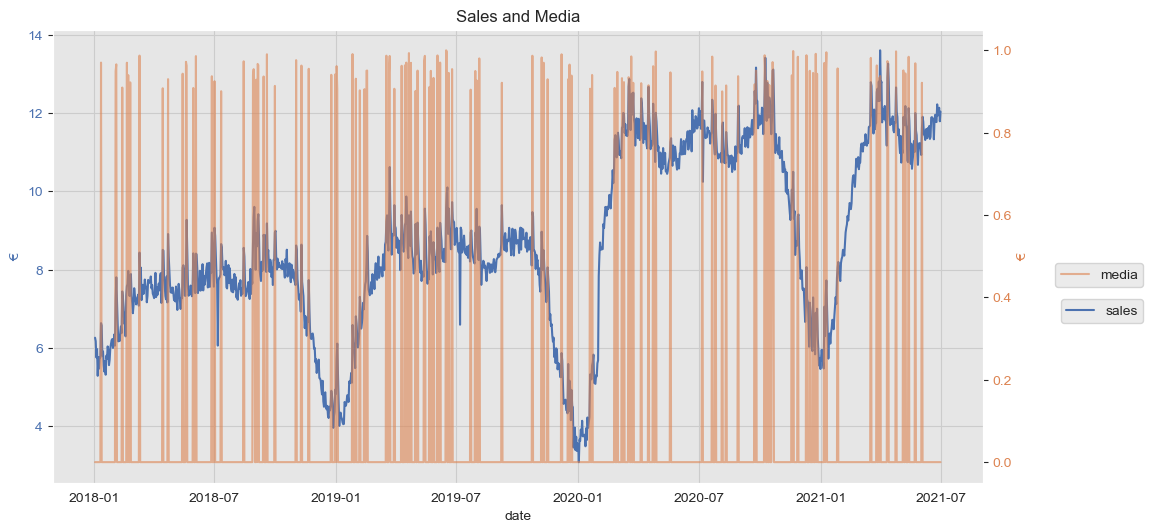

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(x='date', y='sales', data=data_df, color=sns_c[0], label='sales', ax=ax1)
sns.lineplot(x='date', y='media', data=data_df, color=sns_c[1], alpha=0.6, label='media', ax=ax2)
ax1.legend(bbox_to_anchor=(1.18, 0.42))
ax2.legend(bbox_to_anchor=(1.18, 0.5))
ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax1.set_ylabel('y', fontdict={'color': sns_c[0]})
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[1])
ax2.set_ylabel('€', fontdict={'color': sns_c[1]});
ax1.set(title='Sales and Media', xlabel='date', ylabel='€');

## Missing Values

Now we explore some methods to fill missing values. 

**Remark:s**
- When filling missing values is always a good practive to have a mask which to tag filled values, see [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator).
- Before filling missing values try to understand them: Where do they come from? Are they random? Do we expect missing values in future data?

### Generate Missing Values

We begin by creating a new variable `sales_na` which is obtained from `sales` by randomly removing values. 

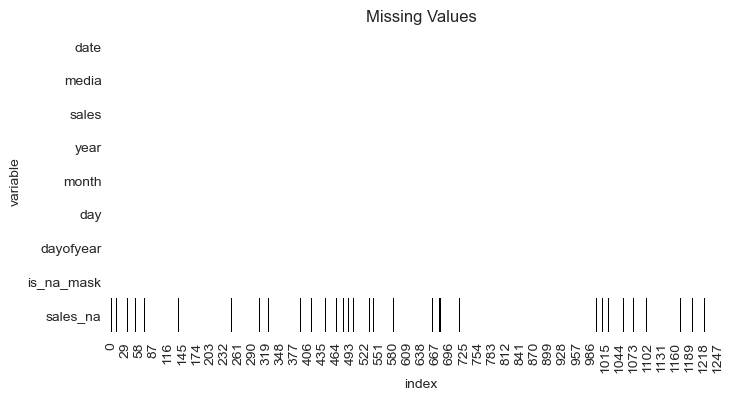

In [18]:
# Set seed.
np.random.seed(seed=42)
# Generate missnig values (raound 5%)
data_df['is_na_mask'] = np.random.binomial(n=1, p=0.05, size=data_df.shape[0]).astype('bool')
data_df = data_df.assign(sales_na = lambda x: np.where(x['is_na_mask'], np.nan, x['sales']))

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(data=data_df.isna().T, cmap='binary', cbar=False, ax=ax)
ax.set(title='Missing Values', xlabel='index', ylabel='variable');

We plot the variable `sales_na` and a missing values indicator function.

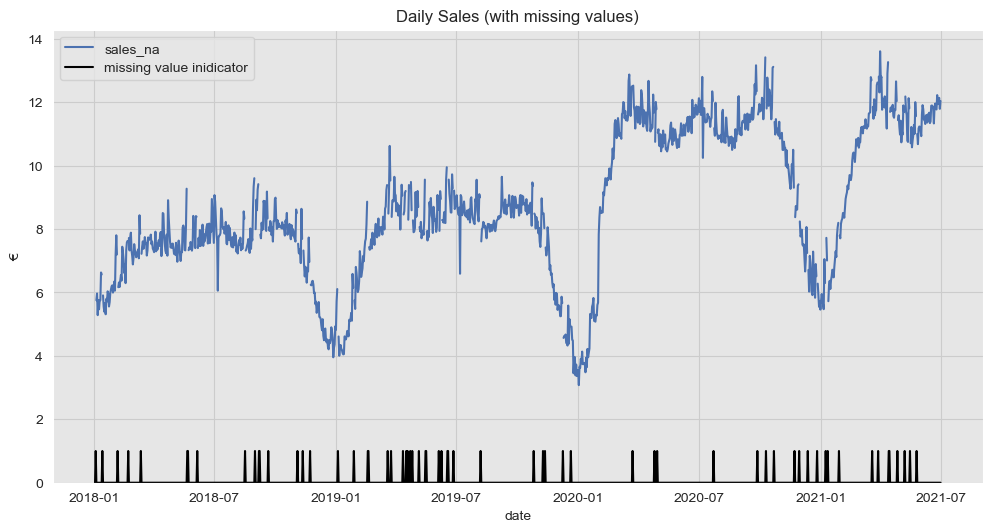

In [19]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales_na', data=data_df, color=sns_c[0], label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=data_df, color='black', label='missing value inidicator',ax=ax)
ax.set(title='Daily Sales (with missing values)', xlabel='date', ylabel='€', ylim=(0, None));

### Fill Missnig Values

Now we apply several methods to fill missing values using [pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) and [scikit-learn](https://scikit-learn.org/stable/modules/impute.html).

In [20]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

data_df = data_df = data_df.assign(
    sales_na_zero = lambda x: SimpleImputer(fill_value=0.0, strategy='constant') \
        .fit_transform(x[['sales_na']]),
    sales_na_mean = lambda x: SimpleImputer(strategy='mean') \
        .fit_transform(x[['sales_na']]),
    sales_na_median = lambda x: SimpleImputer(strategy='median') \
        .fit_transform(x[['sales_na']]),
    sales_na_most_frequent = lambda x: SimpleImputer(strategy='most_frequent') \
        .fit_transform(x[['sales_na']]),
    sales_na_last = lambda x: x['sales_na'].fillna(method='ffill'),
    sales_na_next = lambda x: x['sales_na'].fillna(method='bfill'),
    sales_na_last_next = lambda x: x[['sales_na_last', 'sales_na_next']].mean(axis=1),
    sales_na_knn = lambda x: KNNImputer(n_neighbors=3, weights='distance') \
        .fit_transform(x[['sales_na', 'day', 'month', 'year']])[:, 0],
    sales_na_iterative = lambda x: IterativeImputer() \
        .fit_transform(x[['sales_na', 'day', 'month', 'year']])[:, 0]
)

Let us plot the imputation against the true values.

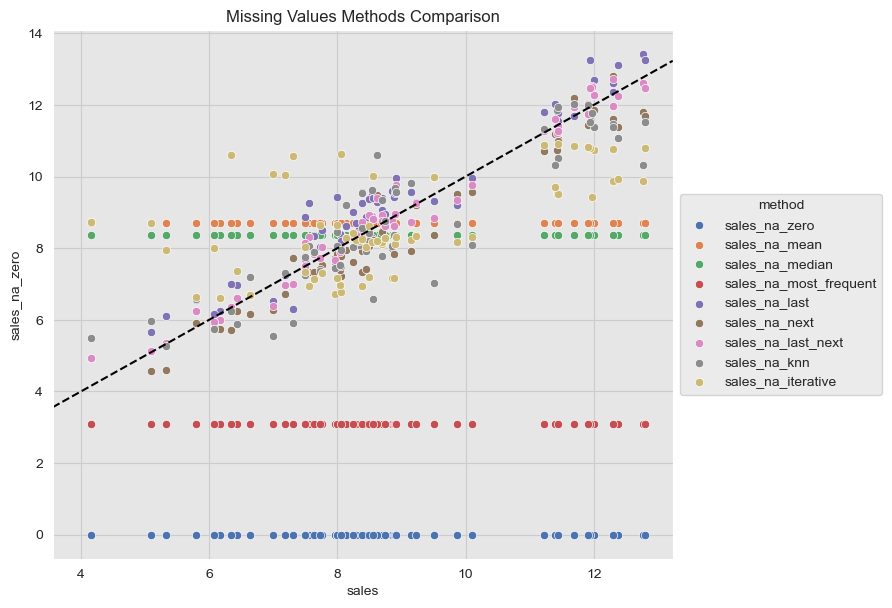

In [21]:
fig, ax = plt.subplots(figsize=(8, 7))
for i, col in enumerate(data_df.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='sales',
        y=col,
        data=data_df.query('sales_na.isnull()'),
        color=sns_c[i],
        label=col,
        ax=ax
    )
ax.axline(xy1=(4, 4), slope=1, color='black', linestyle='--')
ax.legend(title='method', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Missing Values Methods Comparison');

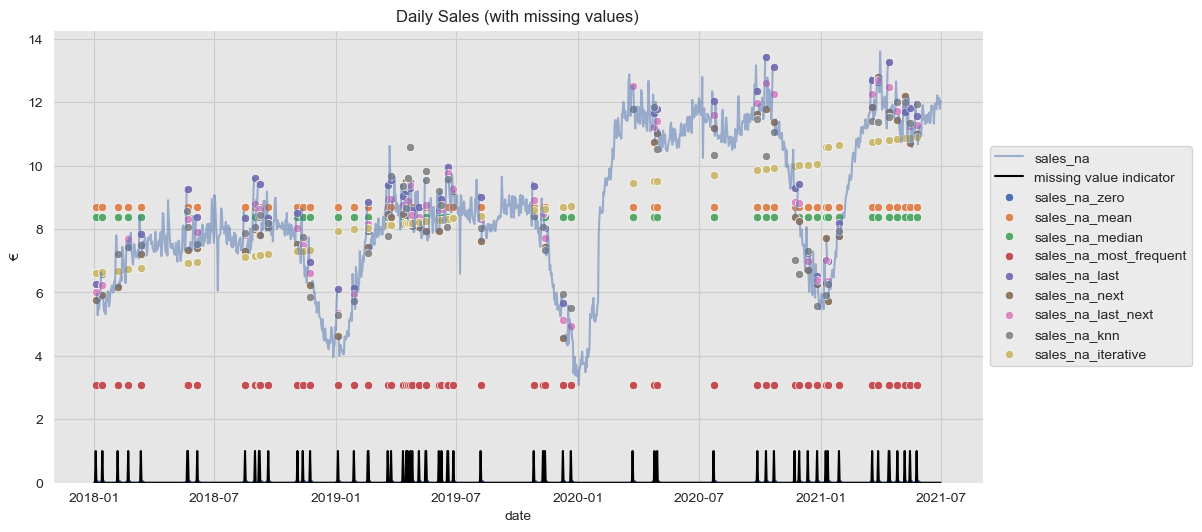

In [22]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales_na', data=data_df, color=sns_c[0], alpha=0.5, label='sales_na', ax=ax)
sns.lineplot(x='date', y='is_na_mask', data=data_df, color='black', label='missing value indicator',ax=ax)
for i, col in enumerate(data_df.filter(regex='sales_na_').columns):
    sns.scatterplot(
        x='date',
        y=col,
        data=data_df.query('sales_na.isnull()'),
        color=sns_c[i],
        label=col,
        ax=ax
    )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Daily Sales (with missing values)', xlabel='date', ylabel='€', ylim=(0, None));

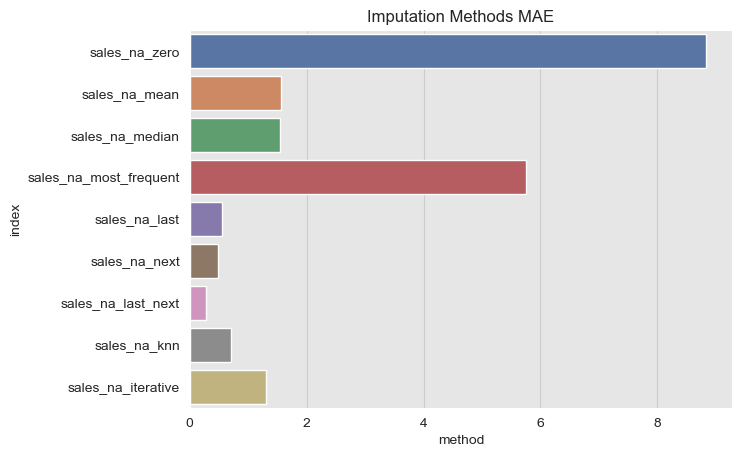

In [23]:
from sklearn.metrics import mean_absolute_error

mae_dict = {}
for col in data_df.filter(regex='sales_na_').columns:
    mae_dict[col] = mean_absolute_error(
        y_true=data_df.query('sales_na.isnull()')['sales'], 
        y_pred=data_df.query('sales_na.isnull()')[col]
    )

fig, ax = plt.subplots(figsize=(7, 5))
pd.DataFrame \
    .from_dict(mae_dict, orient='index', columns=['mae']) \
    .reset_index(drop=False) \
    .pipe((sns.barplot, 'data'),
        y='index', 
        x='mae',
        ax=ax
    )
ax.set(title='Imputation Methods MAE', xlabel='method');

In [24]:
pd.DataFrame \
    .from_dict(mae_dict, orient='index', columns=['mae']) \
    .sort_values('mae')

mae
sales_na_last_next      0.278173
sales_na_next           0.490577
sales_na_last           0.552272
sales_na_knn            0.700502
sales_na_iterative      1.302645
sales_na_median         1.546986
sales_na_mean           1.564852
sales_na_most_frequent  5.759129
sales_na_zero           8.837281

**Results:**
- Since the time series has a trend, filling with a constant value (zero, most, frequent, median and mean) is not appropiate. 
- The [`IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) captures the trend. 
- Forward/Backward fill (ffill/bfill) and [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer) works better. 
- The best imputation method (according to mae) is the mean of the Forward/Backward fill.

**Warning:** This was a over-simplified way of filling missing values. In practice you need to be very careful when eveluating forecasting models via time-slice-cross-validation as you do not want to leak information. For example, you can not always use the backwards fill as you do not know the value of the next point if it's the last one. Also, even if filling with the mean/meadian works fine (e.g. stationary series), you need to make sure you fill missing values with the mean/median of the training fold and not on the whole data set. It is a good practice to add your imputing method as a step in your [pipeline](https://scikit-learn.org/stable/modules/compose.html).